In [1]:
import h5py
import numpy as np

# Load training data
train_dataset = h5py.File('train_catvnoncat.h5', 'r')
X_train = np.array(train_dataset['train_set_x'][:])  # Input images
Y_train = np.array(train_dataset['train_set_y'][:])  # Labels

# Load test data
test_dataset = h5py.File('test_catvnoncat.h5', 'r')
X_test = np.array(test_dataset['test_set_x'][:])
Y_test = np.array(test_dataset['test_set_y'][:])

# Reshape labels for compatibility with PyTorch
Y_train = Y_train.reshape(-1)
Y_test = Y_test.reshape(-1)

print(f"Training set: {X_train.shape}, Labels: {Y_train.shape}")
print(f"Test set: {X_test.shape}, Labels: {Y_test.shape}")


Training set: (209, 64, 64, 3), Labels: (209,)
Test set: (50, 64, 64, 3), Labels: (50,)


In [2]:
student_id_last_digit = 9  # ID's last digit (sbu_id = 116743079)
X_train_new = X_train[:160 + student_id_last_digit]
Y_train_new = Y_train[:160 + student_id_last_digit]
X_test_new = X_train[160 + student_id_last_digit:]
Y_test_new = Y_train[160 + student_id_last_digit:]

print(f"Training set: {X_train_new.shape}, Labels: {Y_train_new.shape}")
print(f"Test set: {X_test_new.shape}, Labels: {Y_test_new.shape}")

Training set: (169, 64, 64, 3), Labels: (169,)
Test set: (40, 64, 64, 3), Labels: (40,)


In [3]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

# Custom dataset class for compatibility with PyTorch
class CatVsNonCatDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            img = self.transform(img)
        
        return img, label

# Define transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize for ResNet
])

# Prepare datasets
train_dataset = CatVsNonCatDataset(X_train_new, Y_train_new, transform=transform)
test_dataset = CatVsNonCatDataset(X_test_new, Y_test_new, transform=transform)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [4]:
import torchvision.models as models
import torch.nn as nn

# Load pre-trained ResNet
model = models.resnet18(weights='IMAGENET1K_V1')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Modify the last layer for binary classification
model.fc = nn.Linear(in_features=model.fc.in_features, out_features=1)  # Output is a single value for binary classification
model = model.to(device)


In [5]:
import torch.optim as optim

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()  # Suitable for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(10): 
    model.train()
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device, dtype=torch.float32)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs).squeeze(1)  # Flatten outputs
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")


Epoch 1, Loss: 0.39785855387647945
Epoch 2, Loss: 0.19090957233371833
Epoch 3, Loss: 0.14621717234452566
Epoch 4, Loss: 0.16358294586340585
Epoch 5, Loss: 0.06065725193669399
Epoch 6, Loss: 0.39119238515074056
Epoch 7, Loss: 0.25834298475335044
Epoch 8, Loss: 0.10365735553205013
Epoch 9, Loss: 0.0994325273980697
Epoch 10, Loss: 0.08703978328655164


In [6]:
model.eval()
correct = 0
total = 0
misclassified_indices = []
prediction_results = []

with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device, dtype=torch.float32)
        
        # Get raw logits
        outputs = model(inputs).squeeze(1)
        
        # Convert logits to predictions
        predictions = torch.round(torch.sigmoid(outputs))
        
        # Update accuracy counts
        total += labels.size(0)
        correct += (predictions == labels).sum().item()
        # Log misclassified indices
        batch_start_idx = i * test_loader.batch_size
        for idx, (pred, label) in enumerate(zip(predictions, labels)):
            if pred != label:
                misclassified_indices.append(batch_start_idx + idx)
            prediction_results.append(pred)

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Misclassified Indices: {misclassified_indices}")


Test Accuracy: 87.50%
Misclassified Indices: [2, 16, 23, 28, 38]


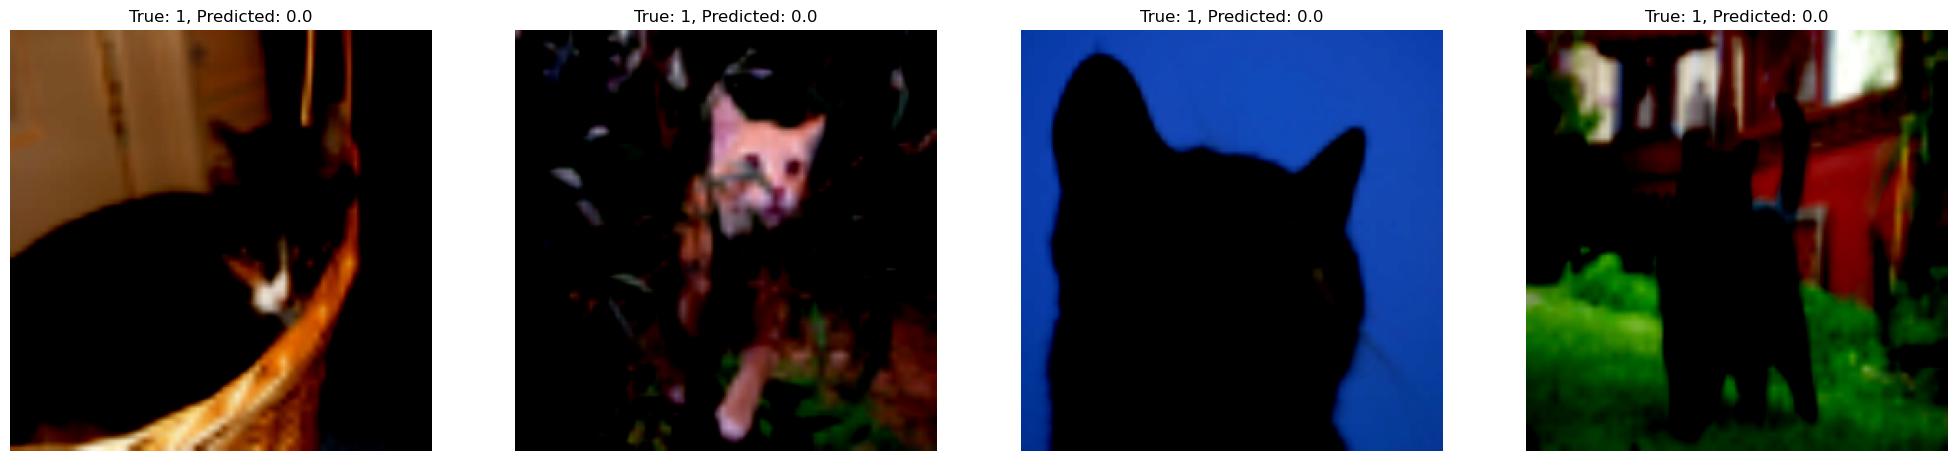

In [8]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 4, figsize=(25, 10))
# Display misclassified images
for i, ax in enumerate(axes):
    idx = misclassified_indices[i]
    img, label = test_dataset[idx]
    ax.imshow(np.clip(img.permute(1, 2, 0), 0, 1))  # Convert CHW to HWC and Clip to [0,1] interval
    ax.set_title(f"True: {label.item()}, Predicted: {prediction_results[idx].item()}")
    ax.axis('off')
plt.show()
